In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
df = pd.read_csv('dataset-tickets-multi-lang-4-20k.csv')

for x in df.index:
    if df.loc[x, 'language'] != 'en':
        df.drop(x, inplace = True)

df.reset_index(drop=True, inplace=True)

df.dropna(subset=['subject', 'body'], inplace=True)

df['text'] = df['subject'] + ' ' + df['body']
df['text'] = df['text'].astype(str)

df = df[['text', 'priority']]


mapping = {'low': 0, 'medium': 0.5, 'high': 1}
df['priority'] = df['priority'].replace(mapping)

df

C:\Users\rayhan\AppData\Local\Temp\ipykernel_26112\3976254451.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['priority'] = df['priority'].replace(mapping)


,text,priority
0,Customer Support Inquiry Seeking information o...,0.5
1,Data Analytics for Investment I am contacting ...,0.5
2,"Security Dear Customer Support, I am reaching ...",0.5
3,Concerns About Securing Medical Data on 2-in-1...,0.5
4,Problem with Integration The integration stopp...,1.0
...,...,...
11916,Support Website Performance Issues Dear Custom...,0.0
11917,Investment Modeling Results Are Inaccurate Det...,0.5
11918,Guidelines for Securing Medical Data in OBS St...,1.0
11920,Support for Marketing Enhancements Request for...,1.0


In [29]:
df['priority'].value_counts()

priority
0.5    4539
1.0    4150
0.0    2201
Name: count, dtype: int64

In [30]:
# Group the data by priority
groups = df.groupby('priority')

# Find the minimum group size
min_size = min(groups.size())

# Sample an equal number of rows from each group
df = groups.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

# Verify the distribution
print(df['priority'].value_counts())

priority
0.0    2201
0.5    2201
1.0    2201
Name: count, dtype: int64


C:\Users\rayhan\AppData\Local\Temp\ipykernel_26112\1902133639.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = groups.apply(lambda x: x.sample(min_size)).reset_index(drop=True)


In [31]:
from collections import Counter

# Tokenize all the texts
tokenized_texts = [text.lower().split() for text in df['text']]

# Build vocabulary manually
counter = Counter()
for tokens in tokenized_texts:
    counter.update(tokens)

# Assign indices
vocab = {"<pad>": 0, "<unk>": 1}
for idx, word in enumerate(counter.keys(), start=2):
    vocab[word] = idx



In [32]:
def tokenize(text):
    return text.lower().split()

def encode(text):
    tokens = tokenize(text)
    return [vocab[token] for token in tokens if token in vocab]

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [vocab["<pad>"]] * (max_len - len(seq))
    else:
        return seq[:max_len]


In [33]:
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded = encode(text)
        padded = pad_sequence(encoded, self.max_len)

        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.float32)


In [34]:
df['encoded'] = df['text'].apply(encode)

In [35]:
df['encoded']

0       [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 5, 14...
1       [74, 75, 76, 7, 8, 77, 78, 21, 74, 79, 71, 80,...
2       [108, 109, 110, 111, 112, 72, 113, 96, 10, 11,...
3       [135, 136, 82, 137, 138, 45, 44, 139, 21, 140,...
4       [67, 141, 131, 155, 71, 156, 29, 157, 158, 6, ...
                              ...                        
6598    [1518, 74, 79, 71, 829, 82, 677, 329, 4299, 72...
6599    [304, 141, 338, 2046, 6, 7, 8, 96, 159, 303, 5...
6600    [135, 3, 421, 155, 71, 674, 1356, 226, 15, 280...
6601    [68, 1159, 194, 185, 976, 137, 192, 240, 7, 8,...
6602    [124, 185, 192, 202, 29, 82, 7717, 34, 55, 194...
Name: encoded, Length: 6603, dtype: object

In [36]:
MAX_LEN = 100

def pad_sequence(seq):
    if len(seq) < MAX_LEN:
        return seq + [0] * (MAX_LEN - len(seq))  # pad with <pad> token (index 0)
    else:
        return seq[:MAX_LEN]  # truncate if too long

df['padded'] = df['encoded'].apply(pad_sequence)


In [37]:
from sklearn.model_selection import train_test_split
import torch

X = list(df['padded'])
y = list(df['priority'])  # your urgency score between 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [38]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [63]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_classes=1):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=5)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(3 * 100, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embed_dim, seq_len)
        
        x1 = F.relu(self.conv1(x)).max(dim=2)[0]
        x2 = F.relu(self.conv2(x)).max(dim=2)[0]
        x3 = F.relu(self.conv3(x)).max(dim=2)[0]
        
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        # x = torch.sigmoid(x)
        return x.squeeze(1)  # because you are predicting a single score


In [64]:
model = TextCNN(vocab_size=len(vocab))

In [65]:
import torch.optim as optim

criterion = nn.MSELoss()  # Because your output is a real-valued score between 0 and 1
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # try 10 epochs
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.7144
Epoch 2, Loss: 0.2521
Epoch 3, Loss: 0.3658
Epoch 4, Loss: 0.1696
Epoch 5, Loss: 0.0885
Epoch 6, Loss: 0.1436
Epoch 7, Loss: 0.4651
Epoch 8, Loss: 0.0718
Epoch 9, Loss: 0.0721
Epoch 10, Loss: 0.0494


In [66]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
print(f"Test Loss: {total_loss / len(test_loader):.4f}")


Test Loss: 0.1560


In [67]:
model.eval()
with torch.no_grad():
    predictions = []
    for inputs in X:
        inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0)  # Add batch dimension
        outputs = model(inputs)
        predictions.append(outputs.item())

df['predicted_priority'] = predictions

In [68]:
df

,text,priority,encoded,padded,predicted_priority
0,Notify About Loading Delays Hello Customer Sup...,0.0,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 5, 14...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 5, 14...",0.261544
1,Security Protocol Improvements Customer Suppor...,0.0,"[74, 75, 76, 7, 8, 77, 78, 21, 74, 79, 71, 80,...","[74, 75, 76, 7, 8, 77, 78, 21, 74, 79, 71, 80,...",0.386210
2,Recent Unexplained Subscription Fees Require A...,0.0,"[108, 109, 110, 111, 112, 72, 113, 96, 10, 11,...","[108, 109, 110, 111, 112, 72, 113, 96, 10, 11,...",0.320432
3,Inquiry Regarding Data Analytics Services Is i...,0.0,"[135, 136, 82, 137, 138, 45, 44, 139, 21, 140,...","[135, 136, 82, 137, 138, 45, 44, 139, 21, 140,...",0.538088
4,Information on Billing Options for Netzteil an...,0.0,"[67, 141, 131, 155, 71, 156, 29, 157, 158, 6, ...","[67, 141, 131, 155, 71, 156, 29, 157, 158, 6, ...",0.329212
...,...,...,...,...,...
6598,Improved Security Protocols for Healthcare Dat...,1.0,"[1518, 74, 79, 71, 829, 82, 677, 329, 4299, 72...","[1518, 74, 79, 71, 829, 82, 677, 329, 4299, 72...",0.921404
6599,Report on Campaign Malfunction Hello Customer ...,1.0,"[304, 141, 338, 2046, 6, 7, 8, 96, 159, 303, 5...","[304, 141, 338, 2046, 6, 7, 8, 96, 159, 303, 5...",0.876200
6600,Inquiry about Training Options for New Employe...,1.0,"[135, 3, 421, 155, 71, 674, 1356, 226, 15, 280...","[135, 3, 421, 155, 71, 674, 1356, 226, 15, 280...",1.030176
6601,Support Request: Issue with Website Analytics ...,1.0,"[68, 1159, 194, 185, 976, 137, 192, 240, 7, 8,...","[68, 1159, 194, 185, 976, 137, 192, 240, 7, 8,...",0.466978


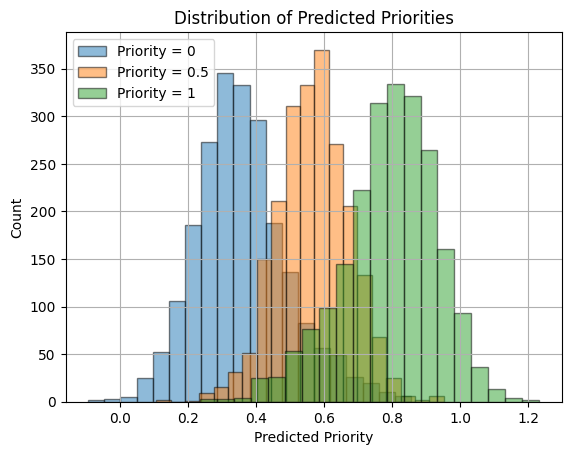

              mean       std
priority                    
0.0       0.360229  0.136315
0.5       0.568318  0.105689
1.0       0.791406  0.140494


In [72]:
# For priority = 0
df[df['priority'] == 0]['predicted_priority'].hist(bins=20, edgecolor='black', alpha=0.5, label='Priority = 0')

# For priority = 0.5
df[df['priority'] == 0.5]['predicted_priority'].hist(bins=20, edgecolor='black', alpha=0.5, label='Priority = 0.5')

# For priority = 1
df[df['priority'] == 1]['predicted_priority'].hist(bins=20, edgecolor='black', alpha=0.5, label='Priority = 1')

plt.xlabel('Predicted Priority')
plt.ylabel('Count')
plt.title('Distribution of Predicted Priorities')
plt.legend()
plt.show()

mean_std = df.groupby('priority')['predicted_priority'].agg(['mean', 'std'])
print(mean_std)

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.tolist())
        actuals.extend(targets.tolist())

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)

# Calculate the percentage of correct predictions
threshold = 0.5
correct = sum((pred >= threshold) == (actual >= threshold) for pred, actual in zip(predictions, actuals))
accuracy = correct / len(actuals) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

Mean Squared Error (MSE): 0.1549
Mean Absolute Error (MAE): 0.3359
Accuracy: 66.54%
